<a href="https://colab.research.google.com/github/PatriciaLucas/Evapotranspiracao/blob/master/Ajusta_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ajusta a base de dados para calcular a Evapotranspiração de Referência
####Patrícia de Oliveira e Lucas
Referência: FAO 56 (2006)

In [0]:
import pandas as pd
from google.colab import files
import math
import numpy as np
from datetime import datetime
import matplotlib as plt
import matplotlib.pyplot as plt

##Upload da base de dados do INMET com ajustes necessários

A base de dados contempla os dados climáticos diários dos anos de 1993 a 2015 da estação meteorológica 83586, localizada na cidade de Sete Lagoas - MG.


Total: 8.400 registros.

In [2]:
uploaded = files.upload()

Saving setelagoas_para ajustar dados climaticos.txt to setelagoas_para ajustar dados climaticos.txt


In [0]:
dataset =  pd.read_csv('setelagoas_para ajustar dados climaticos.txt',delimiter=';')

In [50]:
print('TAMANHO DA BASE DE DADOS: ',dataset.shape[0])
dataset = dataset.reset_index(drop=True)
dataset.head(3)

TAMANHO DA BASE DE DADOS:  8400


,Data,Tmax,Tmin,I,Tmean,UR,V
0,1993-01-01,31.3,15.4,11.3,22.86,64.75,1.366667
1,1993-01-02,33.8,16.1,11.2,23.80,64.50,0.333333
2,1993-01-03,32.1,17.0,9.5,23.92,67.50,2.066667


###Constantes

In [0]:
latitude = -22.89 #--em graus
longitude = -43.18  #--em graus
altitude = 11.10  #--em metros

###Conversão da velocidade do vento medida a 10m para 2m com limite de 0.5 m/s
Equação 47 (FAO 56)

$U_2 = U_z \frac{4.87}{\ln(67.8 z - 5.42)}$

onde:

$U_2$ = velocidade do vento a 2 m sobre a superfície do solo [$m\ s^{-1}$]

$U_z$ =  velocidade do vento medida a z m sobre superfície do solo [$m\ s^{-1}$]

$z$ = altura de medida sobre superfície do solo [$m$]

In [0]:
def conversao_U2(dataset):
    """
    Conversão da velocidade do vento medida a 10m para 2m com limite de 0.5 m/s
    Equação 47 (FAO 56)
    :param dataset: coluna de dados de velocidade do vento

    """
    for i in range(dataset.shape[0]-1): 
      if np.isnan(dataset.loc[i]) == False:
        dataset.loc[i] = dataset.loc[i] * (4.87 / math.log(67.8 * 10 - 5.42)) 
        if dataset.loc[i] < .5:
          dataset.loc[i] = .5
          
    return dataset
dataset['V'] = conversao_U2(dataset['V'])

###Dados faltantes de Velocidade do vento (V) 
Onde nenhum dado de velocidade do vento está disponível dentro da região, pode ser
usado um valor de 2 m/s como uma estimativa temporária.

In [0]:
def completa_U2(dataset):
  """
    Completa a base de dados em caso de dados faltantes de Velocidade do vento 
    :param dataset: coluna de dados de velocidade do vento

  """
  for i in range(dataset.shape[0]-1): 
    if np.isnan(dataset.loc[i]):
      dataset.loc[i] = 2
  return dataset

dataset['V'] = completa_U2(dataset['V'])

###Temperaturas (Tmax, Tmin e Tmean)

Foi utilizada interpolação linear para estimar as tempearturas Máxima e Mínima.

In [0]:
def interpola_T(dataset_Tmax, dataset_Tmin):
    """
    Completa a base de dados em caso de dados faltantes de Temperatura máxima, mínima e média.
    :param dataset_Tmax: coluna de dados com Temperatura máxima.
    :param dataset_Tmin: coluna de dados com Temperatura mínima.
    :return: coluna de dados com Temperatura máxima, mínima e média.
    """
    dataset_Tmax = dataset_Tmax.interpolate(axis = 0)
    dataset_Tmin = dataset_Tmin.interpolate(axis = 0)
    dataset_Tmean = (dataset_Tmax + dataset_Tmin)/2
    return dataset_Tmax, dataset_Tmin, dataset_Tmean

dataset['Tmax'], dataset['Tmin'], dataset['Tmean'] = interpola_T(dataset['Tmax'], dataset['Tmin'])

###Insolação (I)

De acordo com o FAO 56, quando dados de $I$ são desconhecidos a $R_s$(Radiação Extraterrestre) pode ser calculada através das temperaturas máxima e mínima. Dessa forma, não foi estimado nenhum valor para dados faltantes de $I$. Caso seja verificada sua ausência durante o cálculo da $R_s$ é usada a Equação 50.

###Umidade Relativa (RH)

De acordo com o FAO 56, quando dados de $RH$ são desconhecidos a $e_a$(Pressão de vapor atual) pode ser calculada através das temperaturas máxima e mínima. Dessa forma, não foi estimado nenhum valor para dados faltantes de $RH$. Caso seja verificada sua ausência durante o cálculo da $e_a$ é usada a Equação 48.

###Calcula dia do ano e acrescenta na base de dados

In [0]:
def calcula_dia(dataset):
    """
      Calcula dia do ano e acrescenta na base de dados
      :param dataset: base de dados completa
      :return: base de dados + coluna com o dia do ano
    """
    date = dataset['Data']
    day_of_year = []
    for i in range(date.shape[0]):
      adate = datetime.strptime(date[i],"%Y-%m-%d")
      day_of_year.append(adate.timetuple().tm_yday)
    day = np.asarray(day_of_year)
    dayframe=pd.DataFrame(day,columns=['J'])
    d = [dataset,dayframe]
    dataset = pd.concat(d,axis=1)
    return dataset
    
dataset = calcula_dia(dataset)

In [57]:
dataset.head(3)

,Data,Tmax,Tmin,I,Tmean,UR,V,J
0,1993-01-01,31.3,15.4,11.3,23.35,64.75,1.005953,1
1,1993-01-02,33.8,16.1,11.2,24.95,64.50,0.500000,2
2,1993-01-03,32.1,17.0,9.5,24.55,67.50,1.521198,3


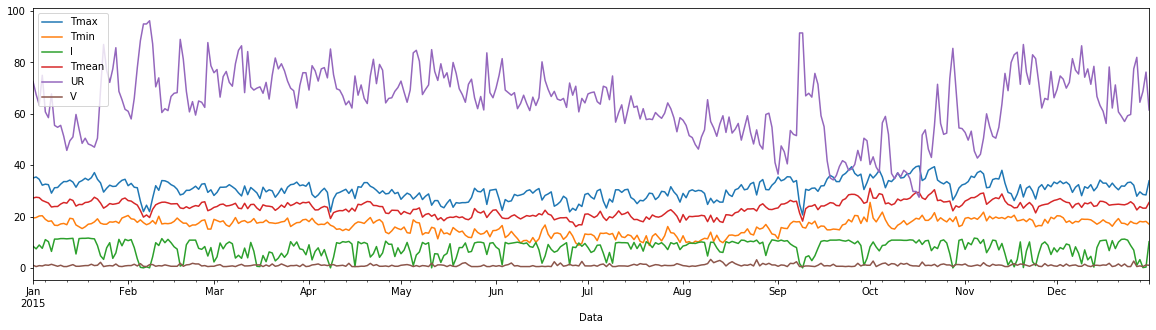

In [58]:
dataplot = dataset.drop(["J"],axis=1)
dataplot.set_index('Data', inplace=True)
dataplot.index = pd.to_datetime(dataplot.index,format='%Y-%m-%d')
dataplot['2015'].plot(figsize=(20,5))

##Download da base de dados ajustada

In [0]:
dataset_ajustado_csv = dataset.to_csv('dataset_ajustado_csv',na_rep='NA', sep=';',index=False)
files.download('dataset_ajustado_csv')